In [1]:
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset,random_split
from vit_pytorch import ViT
from vit_pytorch.vit import Transformer, Attention

/home/exouser/VSCODE_NN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Upload

In [2]:
data_path = "filtered_species"
batch_size = 64

transform = transforms.Compose([
    transforms.CenterCrop((256, 256)),  #Resize to minimum of all sizes - Will update size in cnn architecture
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.RandomRotation(degrees = 30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

data = datasets.ImageFolder(root=data_path, transform=transform)


subset_size = 5000
indices = random.sample(range(len(data)), subset_size)
data_subset = Subset(data, indices)

#change data_subset <-> data for train from whole data
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
training, testing = random_split(data, [train_size, test_size], generator=torch.Generator().manual_seed(1111))

training_dataset = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
testing_dataset = DataLoader(testing, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
#For testing purposes
#print("Class names:", data.classes)
#len(data.classes)

### Classifier Architecture

In [3]:
class BirdClassifier(nn.Module):
    def __init__(self,
                 cnn_state=False,                # Whether to use CNN before ViT
                 image_size=256,
                 patch_size=16,
                 num_class=10,
                 dim=256,
                 layer_count=1,
                 head_count=1,
                 transformer_ff_neurons=256,
                 transformer_dropout=0.2):
        super().__init__()
        
        self.cnn_state = cnn_state
        self.image_size = image_size if not cnn_state else 64  # Will update if CNN is used

        if cnn_state:
            self.cnn = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # AlexNet
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                
                nn.Conv2d(96, 256, kernel_size=5, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),

                nn.Conv2d(256, 384, kernel_size=3, padding=1),
                nn.ReLU(),

                nn.Conv2d(384, 384, kernel_size=3, padding=1),
                nn.ReLU(),

                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d((self.image_size, self.image_size))  # Resize to ViT input
            )

        self.vision_transformer = ViT(
            image_size=self.image_size,
            patch_size=patch_size,
            num_classes=num_class,
            dim=dim,
            depth=layer_count,
            heads=head_count,
            mlp_dim=transformer_ff_neurons,
            dropout=transformer_dropout,
            emb_dropout=transformer_dropout,
            channels=3
        )

    def forward(self, x):
        if self.cnn_state:
            x = self.cnn(x)
        x = self.vision_transformer(x)
        return x

    def print_config(self):
        print(f"Using CNN: {self.cnn_state}")
        print(f"ViT dim: {self.vision_transformer.dim}, layers: {self.vision_transformer.depth}")




In [4]:
def train_model(model, dataloader, criterion, optimizer_metric, accuracy_metric, device):
    model.train()
    net_loss = 0
    for images, labels in tqdm(dataloader, desc = "TRAINIGN"):
        images, labels = images.to(device), labels.to(device)
        y_hat = model(images)
        loss = criterion(y_hat, labels)
        optimizer_metric.zero_grad()
        loss.backward()
        optimizer_metric.step()
        accuracy_metric.update(y_hat, labels)
        net_loss += loss.item()
    
    epoch_accuracy = accuracy_metric.compute().item()
    epoch_loss = net_loss/(len(dataloader))

    return epoch_accuracy, epoch_loss

def test_model(model, dataloader, criterion, accuracy_metric, device):
    model.eval()
    net_loss = 0
    for images, labels in tqdm(dataloader, desc = "TESTING"):
        image, label = images.to(device), labels.to(device)
        y_hat = model(image)
        loss = criterion(y_hat, label)
        accuracy_metric.update(y_hat, label)
        net_loss += loss.item()
    
    epoch_accuracy = accuracy_metric.compute().item()
    epoch_loss = net_loss/(len(dataloader))

    return epoch_accuracy, epoch_loss

### Baseline Model (Control)

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BirdClassifier(cnn_state=False).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train = []
accuracy_scores_train = []
loss_scores_test = []
accuracy_scores_test = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train.append(train_acc)
    loss_scores_train.append(train_loss)

    accuracy_scores_test.append(test_acc)
    loss_scores_test.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    scheduler.step()
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.29it/s]


Train Acc: 0.2032 | Train Loss: 2.1571 | Test Acc: 0.2108 | Test Loss: 2.071815055243823

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.61it/s]


Train Acc: 0.2321 | Train Loss: 2.0427 | Test Acc: 0.2365 | Test Loss: 2.0136976428583364

Epoch 3


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.08it/s]


Train Acc: 0.2501 | Train Loss: 1.9862 | Test Acc: 0.2537 | Test Loss: 1.9310644208168497

Epoch 4


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.21it/s]


Train Acc: 0.2626 | Train Loss: 1.9569 | Test Acc: 0.2649 | Test Loss: 1.9408069427321557

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.87it/s]


Train Acc: 0.2714 | Train Loss: 1.9394 | Test Acc: 0.2732 | Test Loss: 1.9254015400296165

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.26it/s]


Train Acc: 0.2786 | Train Loss: 1.9221 | Test Acc: 0.2801 | Test Loss: 1.899029370067882

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.61it/s]


Train Acc: 0.2842 | Train Loss: 1.9129 | Test Acc: 0.2855 | Test Loss: 1.8911463654771143

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.07it/s]


Train Acc: 0.2891 | Train Loss: 1.8975 | Test Acc: 0.2902 | Test Loss: 1.880064995921388

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.27it/s]


Train Acc: 0.2932 | Train Loss: 1.8901 | Test Acc: 0.2941 | Test Loss: 1.858961404586325

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.31it/s]


Train Acc: 0.2968 | Train Loss: 1.8801 | Test Acc: 0.2974 | Test Loss: 1.874437806557636

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.87it/s]


Train Acc: 0.3004 | Train Loss: 1.8557 | Test Acc: 0.3011 | Test Loss: 1.8398119121992669

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.45it/s]


Train Acc: 0.3036 | Train Loss: 1.8435 | Test Acc: 0.3042 | Test Loss: 1.866578685994051

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.76it/s]


Train Acc: 0.3066 | Train Loss: 1.8441 | Test Acc: 0.3072 | Test Loss: 1.8262993527107498

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.46it/s]


Train Acc: 0.3092 | Train Loss: 1.8380 | Test Acc: 0.3098 | Test Loss: 1.8361572757059215
No improvement. Early stopping counter: 1/3

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.71it/s]


Train Acc: 0.3116 | Train Loss: 1.8337 | Test Acc: 0.3122 | Test Loss: 1.8233803129520545

Epoch 16


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.42it/s]


Train Acc: 0.3139 | Train Loss: 1.8330 | Test Acc: 0.3144 | Test Loss: 1.8245288993225617
No improvement. Early stopping counter: 1/3

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.40it/s]


Train Acc: 0.3159 | Train Loss: 1.8250 | Test Acc: 0.3163 | Test Loss: 1.8345141840629837

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.50it/s]


Train Acc: 0.3177 | Train Loss: 1.8313 | Test Acc: 0.3180 | Test Loss: 1.8456723268340234
No improvement. Early stopping counter: 1/3

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.58it/s]


Train Acc: 0.3193 | Train Loss: 1.8232 | Test Acc: 0.3198 | Test Loss: 1.8120913740728988

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.95it/s]


Train Acc: 0.3210 | Train Loss: 1.8208 | Test Acc: 0.3212 | Test Loss: 1.8574426076850112
No improvement. Early stopping counter: 1/3

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.76it/s]


Train Acc: 0.3224 | Train Loss: 1.8118 | Test Acc: 0.3228 | Test Loss: 1.7909330916242534

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.14it/s]


Train Acc: 0.3240 | Train Loss: 1.8077 | Test Acc: 0.3244 | Test Loss: 1.7996359958129675
No improvement. Early stopping counter: 1/3

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.86it/s]


Train Acc: 0.3254 | Train Loss: 1.8069 | Test Acc: 0.3257 | Test Loss: 1.8098255785144106
No improvement. Early stopping counter: 2/3

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.53it/s]


Train Acc: 0.3267 | Train Loss: 1.8032 | Test Acc: 0.3270 | Test Loss: 1.8108549207246223

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.90it/s]


Train Acc: 0.3280 | Train Loss: 1.8014 | Test Acc: 0.3282 | Test Loss: 1.8037900000202411
No improvement. Early stopping counter: 1/3

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.68it/s]


Train Acc: 0.3291 | Train Loss: 1.8012 | Test Acc: 0.3294 | Test Loss: 1.8146127640795546
No improvement. Early stopping counter: 2/3

Epoch 27


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.62it/s]


Train Acc: 0.3302 | Train Loss: 1.8033 | Test Acc: 0.3304 | Test Loss: 1.7960099792804847

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.10it/s]


Train Acc: 0.3311 | Train Loss: 1.8028 | Test Acc: 0.3314 | Test Loss: 1.8031347754861222
No improvement. Early stopping counter: 1/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.18it/s]


Train Acc: 0.3320 | Train Loss: 1.8043 | Test Acc: 0.3322 | Test Loss: 1.8095750208614634
No improvement. Early stopping counter: 2/3

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.00it/s]

Train Acc: 0.3329 | Train Loss: 1.7990 | Test Acc: 0.3331 | Test Loss: 1.8265813134965443
No improvement. Early stopping counter: 3/3
Early stopping triggered.


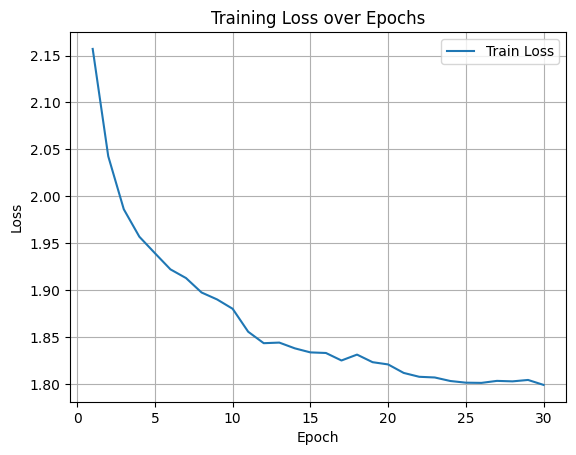

In [6]:
x = list(range(1, len(loss_scores_train) + 1))

plt.figure()
plt.plot(x, loss_scores_train, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

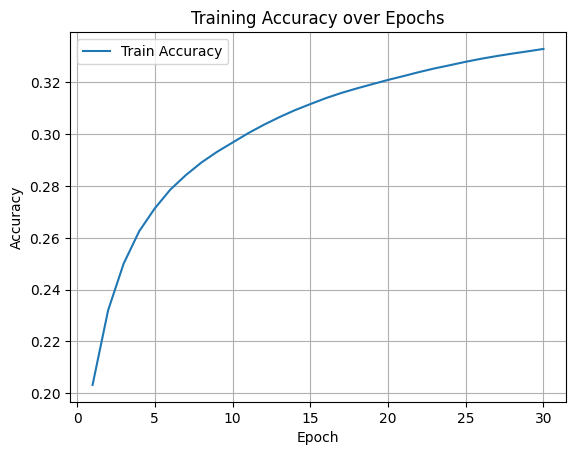

In [7]:
plt.figure()
plt.plot(x, accuracy_scores_train, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
torch.save(model.state_dict(), "bird_classifier_3.pth")

### Experiment 1 - Multihead

baseline is one,  test 2 then 4 then 8

2 heads

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_multihead_2 = BirdClassifier(cnn_state=False, head_count= 2).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multihead_2.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multihead_2 = []
accuracy_scores_train_multihead_2 = []

loss_scores_test_multihead_2 = []
accuracy_scores_test_multihead_2 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multihead_2, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multihead_2, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multihead_2.append(train_acc)
    loss_scores_train_multihead_2.append(train_loss)

    accuracy_scores_test_multihead_2.append(test_acc)
    loss_scores_test_multihead_2.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.66it/s]


Train Acc: 0.2438 | Train Loss: 2.0679 | Test Acc: 0.2564 | Test Loss: 1.9623219910122098

Epoch 2


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.99it/s]


Train Acc: 0.2763 | Train Loss: 1.9481 | Test Acc: 0.2824 | Test Loss: 1.8805942965202591

Epoch 3


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.75it/s]


Train Acc: 0.2935 | Train Loss: 1.8992 | Test Acc: 0.2956 | Test Loss: 1.8957052255163387

Epoch 4


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.64it/s]


Train Acc: 0.3033 | Train Loss: 1.8668 | Test Acc: 0.3057 | Test Loss: 1.8587747009433047

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.51it/s]


Train Acc: 0.3120 | Train Loss: 1.8451 | Test Acc: 0.3143 | Test Loss: 1.7932055377635827

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.95it/s]


Train Acc: 0.3195 | Train Loss: 1.8214 | Test Acc: 0.3209 | Test Loss: 1.832589601172882

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.60it/s]


Train Acc: 0.3259 | Train Loss: 1.7965 | Test Acc: 0.3269 | Test Loss: 1.8193938415877673

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.56it/s]


Train Acc: 0.3308 | Train Loss: 1.7879 | Test Acc: 0.3320 | Test Loss: 1.787510710508645

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.90it/s]


Train Acc: 0.3358 | Train Loss: 1.7740 | Test Acc: 0.3366 | Test Loss: 1.7927452650199942

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.25it/s]


Train Acc: 0.3398 | Train Loss: 1.7644 | Test Acc: 0.3407 | Test Loss: 1.7464452422395045

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.79it/s]


Train Acc: 0.3435 | Train Loss: 1.7548 | Test Acc: 0.3444 | Test Loss: 1.7391238042286463

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.67it/s]


Train Acc: 0.3469 | Train Loss: 1.7463 | Test Acc: 0.3475 | Test Loss: 1.7657955901152422

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.98it/s]


Train Acc: 0.3497 | Train Loss: 1.7360 | Test Acc: 0.3505 | Test Loss: 1.710728401229495

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.64it/s]


Train Acc: 0.3525 | Train Loss: 1.7326 | Test Acc: 0.3530 | Test Loss: 1.75510573711525
No improvement. Early stopping counter: 1/3

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.09it/s]


Train Acc: 0.3549 | Train Loss: 1.7232 | Test Acc: 0.3556 | Test Loss: 1.6925215080481808

Epoch 16


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.35it/s]


Train Acc: 0.3573 | Train Loss: 1.7230 | Test Acc: 0.3578 | Test Loss: 1.7040958574840002
No improvement. Early stopping counter: 1/3

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.25it/s]


Train Acc: 0.3596 | Train Loss: 1.7157 | Test Acc: 0.3599 | Test Loss: 1.7506412267684937

Epoch 18


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.79it/s]


Train Acc: 0.3614 | Train Loss: 1.7125 | Test Acc: 0.3619 | Test Loss: 1.6973216038982883
No improvement. Early stopping counter: 1/3

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.23it/s]


Train Acc: 0.3634 | Train Loss: 1.7054 | Test Acc: 0.3637 | Test Loss: 1.7193131957735335

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.73it/s]


Train Acc: 0.3651 | Train Loss: 1.7065 | Test Acc: 0.3655 | Test Loss: 1.7131314050583613
No improvement. Early stopping counter: 1/3

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.41it/s]


Train Acc: 0.3667 | Train Loss: 1.7014 | Test Acc: 0.3671 | Test Loss: 1.6790578722142848

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.03it/s]


Train Acc: 0.3682 | Train Loss: 1.6984 | Test Acc: 0.3686 | Test Loss: 1.6759938634171778
No improvement. Early stopping counter: 1/3

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.37it/s]


Train Acc: 0.3698 | Train Loss: 1.6923 | Test Acc: 0.3701 | Test Loss: 1.6872549194867918

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.85it/s]


Train Acc: 0.3713 | Train Loss: 1.6895 | Test Acc: 0.3716 | Test Loss: 1.7003118529611705
No improvement. Early stopping counter: 1/3

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.26it/s]


Train Acc: 0.3726 | Train Loss: 1.6915 | Test Acc: 0.3729 | Test Loss: 1.6834314575000686
No improvement. Early stopping counter: 2/3

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.04it/s]


Train Acc: 0.3739 | Train Loss: 1.6854 | Test Acc: 0.3741 | Test Loss: 1.713954097559663

Epoch 27


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.70it/s]


Train Acc: 0.3751 | Train Loss: 1.6822 | Test Acc: 0.3754 | Test Loss: 1.6645978308048377
No improvement. Early stopping counter: 1/3

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.61it/s]


Train Acc: 0.3764 | Train Loss: 1.6764 | Test Acc: 0.3767 | Test Loss: 1.6568772817144588
No improvement. Early stopping counter: 2/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.30it/s]


Train Acc: 0.3775 | Train Loss: 1.6768 | Test Acc: 0.3778 | Test Loss: 1.6955910823783096

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.60it/s]


Train Acc: 0.3785 | Train Loss: 1.6774 | Test Acc: 0.3788 | Test Loss: 1.680574309258234
No improvement. Early stopping counter: 1/3

Epoch 31


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.08it/s]


Train Acc: 0.3796 | Train Loss: 1.6758 | Test Acc: 0.3798 | Test Loss: 1.6741265577523887
No improvement. Early stopping counter: 2/3

Epoch 32


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.77it/s]

Train Acc: 0.3806 | Train Loss: 1.6762 | Test Acc: 0.3807 | Test Loss: 1.6899487647880502
No improvement. Early stopping counter: 3/3
Early stopping triggered.


4 heads

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_multihead_4 = BirdClassifier(cnn_state=False, head_count = 4).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multihead_4.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multihead_4 = []
accuracy_scores_train_multihead_4 = []

loss_scores_test_multihead_4 = []
accuracy_scores_test_multihead_4 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multihead_4, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multihead_4, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multihead_4.append(train_acc)
    loss_scores_train_multihead_4.append(train_loss)

    accuracy_scores_test_multihead_4.append(test_acc)
    loss_scores_test_multihead_4.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.48it/s]


Train Acc: 0.2611 | Train Loss: 2.0321 | Test Acc: 0.2732 | Test Loss: 1.9193107116790045

Epoch 2


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.94it/s]


Train Acc: 0.2934 | Train Loss: 1.9028 | Test Acc: 0.2989 | Test Loss: 1.8408062498585707

Epoch 3


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.63it/s]


Train Acc: 0.3118 | Train Loss: 1.8475 | Test Acc: 0.3161 | Test Loss: 1.7963673573772923

Epoch 4


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.44it/s]


Train Acc: 0.3240 | Train Loss: 1.8136 | Test Acc: 0.3268 | Test Loss: 1.7556094766474095

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.22it/s]


Train Acc: 0.3333 | Train Loss: 1.7816 | Test Acc: 0.3355 | Test Loss: 1.7383225848074673

Epoch 6


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.46it/s]


Train Acc: 0.3409 | Train Loss: 1.7610 | Test Acc: 0.3425 | Test Loss: 1.7630439988609885

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.06it/s]


Train Acc: 0.3474 | Train Loss: 1.7360 | Test Acc: 0.3489 | Test Loss: 1.6953809236993596

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.28it/s]


Train Acc: 0.3532 | Train Loss: 1.7186 | Test Acc: 0.3548 | Test Loss: 1.6626940835900859

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.29it/s]


Train Acc: 0.3583 | Train Loss: 1.7073 | Test Acc: 0.3593 | Test Loss: 1.7084682717615245

Epoch 10


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.65it/s]


Train Acc: 0.3626 | Train Loss: 1.6904 | Test Acc: 0.3636 | Test Loss: 1.6928604938546006

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.81it/s]


Train Acc: 0.3666 | Train Loss: 1.6842 | Test Acc: 0.3675 | Test Loss: 1.680660180494088

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.04it/s]


Train Acc: 0.3701 | Train Loss: 1.6756 | Test Acc: 0.3710 | Test Loss: 1.6259520013316149

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.34it/s]


Train Acc: 0.3733 | Train Loss: 1.6642 | Test Acc: 0.3742 | Test Loss: 1.643862626179546

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.84it/s]


Train Acc: 0.3763 | Train Loss: 1.6592 | Test Acc: 0.3770 | Test Loss: 1.6380604821808484
No improvement. Early stopping counter: 1/3

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.60it/s]


Train Acc: 0.3791 | Train Loss: 1.6497 | Test Acc: 0.3799 | Test Loss: 1.6225021428802386

Epoch 16


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.66it/s]


Train Acc: 0.3817 | Train Loss: 1.6502 | Test Acc: 0.3822 | Test Loss: 1.653762082664334
No improvement. Early stopping counter: 1/3

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.44it/s]


Train Acc: 0.3840 | Train Loss: 1.6379 | Test Acc: 0.3845 | Test Loss: 1.6305295099206523

Epoch 18


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.59it/s]


Train Acc: 0.3861 | Train Loss: 1.6349 | Test Acc: 0.3867 | Test Loss: 1.5989974137066172
No improvement. Early stopping counter: 1/3

Epoch 19


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.71it/s]


Train Acc: 0.3882 | Train Loss: 1.6270 | Test Acc: 0.3888 | Test Loss: 1.6148294445608748

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.40it/s]


Train Acc: 0.3903 | Train Loss: 1.6245 | Test Acc: 0.3907 | Test Loss: 1.631980445109257
No improvement. Early stopping counter: 1/3

Epoch 21


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.89it/s]


Train Acc: 0.3920 | Train Loss: 1.6168 | Test Acc: 0.3924 | Test Loss: 1.63835186293336

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.21it/s]


Train Acc: 0.3937 | Train Loss: 1.6170 | Test Acc: 0.3943 | Test Loss: 1.5880186257719182
No improvement. Early stopping counter: 1/3

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.14it/s]


Train Acc: 0.3955 | Train Loss: 1.6079 | Test Acc: 0.3959 | Test Loss: 1.5863426931861306

Epoch 24


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.84it/s]


Train Acc: 0.3972 | Train Loss: 1.6044 | Test Acc: 0.3975 | Test Loss: 1.5936770982482806
No improvement. Early stopping counter: 1/3

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.04it/s]


Train Acc: 0.3987 | Train Loss: 1.6038 | Test Acc: 0.3991 | Test Loss: 1.6016073575636156

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.46it/s]


Train Acc: 0.4004 | Train Loss: 1.6000 | Test Acc: 0.4007 | Test Loss: 1.6132835887727284
No improvement. Early stopping counter: 1/3

Epoch 27


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.67it/s]


Train Acc: 0.4019 | Train Loss: 1.5899 | Test Acc: 0.4022 | Test Loss: 1.567245669105426

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.64it/s]


Train Acc: 0.4033 | Train Loss: 1.5869 | Test Acc: 0.4036 | Test Loss: 1.640520835409359
No improvement. Early stopping counter: 1/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.85it/s]


Train Acc: 0.4046 | Train Loss: 1.5854 | Test Acc: 0.4050 | Test Loss: 1.579225136309254
No improvement. Early stopping counter: 2/3

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.65it/s]


Train Acc: 0.4059 | Train Loss: 1.5859 | Test Acc: 0.4062 | Test Loss: 1.5709280375720693

Epoch 31


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.85it/s]


Train Acc: 0.4072 | Train Loss: 1.5804 | Test Acc: 0.4074 | Test Loss: 1.5919915486355216
No improvement. Early stopping counter: 1/3

Epoch 32


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.09it/s]


Train Acc: 0.4084 | Train Loss: 1.5751 | Test Acc: 0.4086 | Test Loss: 1.6290372439793177
No improvement. Early stopping counter: 2/3

Epoch 33


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.29it/s]


Train Acc: 0.4094 | Train Loss: 1.5779 | Test Acc: 0.4097 | Test Loss: 1.5686572190044688

Epoch 34


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.89it/s]


Train Acc: 0.4106 | Train Loss: 1.5731 | Test Acc: 0.4109 | Test Loss: 1.570054827093267
No improvement. Early stopping counter: 1/3

Epoch 35


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.47it/s]


Train Acc: 0.4116 | Train Loss: 1.5740 | Test Acc: 0.4118 | Test Loss: 1.5895970289399024
No improvement. Early stopping counter: 2/3

Epoch 36


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.99it/s]


Train Acc: 0.4126 | Train Loss: 1.5674 | Test Acc: 0.4129 | Test Loss: 1.5481250626700265

Epoch 37


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.38it/s]


Train Acc: 0.4137 | Train Loss: 1.5659 | Test Acc: 0.4139 | Test Loss: 1.6008640235784102
No improvement. Early stopping counter: 1/3

Epoch 38


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.38it/s]


Train Acc: 0.4147 | Train Loss: 1.5616 | Test Acc: 0.4150 | Test Loss: 1.5409515641984486
No improvement. Early stopping counter: 2/3

Epoch 39


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.26it/s]

Train Acc: 0.4157 | Train Loss: 1.5634 | Test Acc: 0.4159 | Test Loss: 1.5513021840530188
No improvement. Early stopping counter: 3/3
Early stopping triggered.


8 head

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_multihead_8 = BirdClassifier(cnn_state=False, head_count = 8).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multihead_8.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multihead_8 = []
accuracy_scores_train_multihead_8 = []

loss_scores_test_multihead_8 = []
accuracy_scores_test_multihead_8 = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multihead_8, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multihead_8, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multihead_8.append(train_acc)
    loss_scores_train_multihead_8.append(train_loss)

    accuracy_scores_test_multihead_8.append(test_acc)
    loss_scores_test_multihead_8.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TRAINIGN:   0%|          | 0/587 [00:00<?, ?it/s]

TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.57it/s]


Train Acc: 0.2878 | Train Loss: 1.9868 | Test Acc: 0.3002 | Test Loss: 1.8502728963384822

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.89it/s]


Train Acc: 0.3212 | Train Loss: 1.8474 | Test Acc: 0.3261 | Test Loss: 1.7821824250578069

Epoch 3


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.62it/s]


Train Acc: 0.3383 | Train Loss: 1.7826 | Test Acc: 0.3409 | Test Loss: 1.7984415268411442

Epoch 4


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.77it/s]


Train Acc: 0.3496 | Train Loss: 1.7494 | Test Acc: 0.3521 | Test Loss: 1.7294531265894573

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.17it/s]


Train Acc: 0.3592 | Train Loss: 1.7196 | Test Acc: 0.3613 | Test Loss: 1.694347973583507

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.75it/s]


Train Acc: 0.3677 | Train Loss: 1.6863 | Test Acc: 0.3687 | Test Loss: 1.7402250190981392

Epoch 7


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.81it/s]


Train Acc: 0.3735 | Train Loss: 1.6715 | Test Acc: 0.3751 | Test Loss: 1.6277688838997666

Epoch 8


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.72it/s]


Train Acc: 0.3798 | Train Loss: 1.6516 | Test Acc: 0.3813 | Test Loss: 1.6151956287371059

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.62it/s]


Train Acc: 0.3850 | Train Loss: 1.6367 | Test Acc: 0.3863 | Test Loss: 1.6163799592426844

Epoch 10


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.06it/s]


Train Acc: 0.3900 | Train Loss: 1.6266 | Test Acc: 0.3911 | Test Loss: 1.5903247140702748

Epoch 11


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.72it/s]


Train Acc: 0.3942 | Train Loss: 1.6142 | Test Acc: 0.3952 | Test Loss: 1.5761675169678773

Epoch 12


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.79it/s]


Train Acc: 0.3981 | Train Loss: 1.6051 | Test Acc: 0.3990 | Test Loss: 1.574352131408899

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.67it/s]


Train Acc: 0.4016 | Train Loss: 1.5976 | Test Acc: 0.4023 | Test Loss: 1.5997630965952971

Epoch 14


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.20it/s]


Train Acc: 0.4048 | Train Loss: 1.5884 | Test Acc: 0.4055 | Test Loss: 1.5851137702967846

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.77it/s]


Train Acc: 0.4078 | Train Loss: 1.5783 | Test Acc: 0.4085 | Test Loss: 1.5442825158437092

Epoch 16


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.28it/s]


Train Acc: 0.4105 | Train Loss: 1.5734 | Test Acc: 0.4111 | Test Loss: 1.549436478387742
No improvement. Early stopping counter: 1/3

Epoch 17


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.15it/s]


Train Acc: 0.4132 | Train Loss: 1.5666 | Test Acc: 0.4137 | Test Loss: 1.5322471021794948

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.90it/s]


Train Acc: 0.4155 | Train Loss: 1.5610 | Test Acc: 0.4161 | Test Loss: 1.5143731735190566
No improvement. Early stopping counter: 1/3

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.67it/s]


Train Acc: 0.4179 | Train Loss: 1.5493 | Test Acc: 0.4183 | Test Loss: 1.5621922445946

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.70it/s]


Train Acc: 0.4200 | Train Loss: 1.5466 | Test Acc: 0.4205 | Test Loss: 1.5220398229806602
No improvement. Early stopping counter: 1/3

Epoch 21


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.11it/s]


Train Acc: 0.4220 | Train Loss: 1.5416 | Test Acc: 0.4225 | Test Loss: 1.5273480188278925

Epoch 22


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.90it/s]


Train Acc: 0.4240 | Train Loss: 1.5292 | Test Acc: 0.4244 | Test Loss: 1.5261291306035047
No improvement. Early stopping counter: 1/3

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.08it/s]


Train Acc: 0.4259 | Train Loss: 1.5302 | Test Acc: 0.4263 | Test Loss: 1.5126353688791496

Epoch 24


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.29it/s]


Train Acc: 0.4275 | Train Loss: 1.5305 | Test Acc: 0.4279 | Test Loss: 1.519972527108225
No improvement. Early stopping counter: 1/3

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.08it/s]


Train Acc: 0.4293 | Train Loss: 1.5192 | Test Acc: 0.4296 | Test Loss: 1.5270310583568754

Epoch 26


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.53it/s]


Train Acc: 0.4309 | Train Loss: 1.5164 | Test Acc: 0.4312 | Test Loss: 1.495775275489911
No improvement. Early stopping counter: 1/3

Epoch 27


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.17it/s]


Train Acc: 0.4325 | Train Loss: 1.5123 | Test Acc: 0.4328 | Test Loss: 1.5162473827803216

Epoch 28


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.20it/s]


Train Acc: 0.4338 | Train Loss: 1.5067 | Test Acc: 0.4342 | Test Loss: 1.487141387803214
No improvement. Early stopping counter: 1/3

Epoch 29


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.24it/s]


Train Acc: 0.4353 | Train Loss: 1.5041 | Test Acc: 0.4357 | Test Loss: 1.4683641706194197
No improvement. Early stopping counter: 2/3

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.50it/s]


Train Acc: 0.4367 | Train Loss: 1.4963 | Test Acc: 0.4371 | Test Loss: 1.4639081650850725

Epoch 31


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.98it/s]


Train Acc: 0.4382 | Train Loss: 1.4977 | Test Acc: 0.4385 | Test Loss: 1.4950609823473457
No improvement. Early stopping counter: 1/3

Epoch 32


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.28it/s]


Train Acc: 0.4395 | Train Loss: 1.4942 | Test Acc: 0.4397 | Test Loss: 1.491560810277251
No improvement. Early stopping counter: 2/3

Epoch 33


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.90it/s]


Train Acc: 0.4408 | Train Loss: 1.4854 | Test Acc: 0.4411 | Test Loss: 1.5017885950957837

Epoch 34


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.38it/s]


Train Acc: 0.4419 | Train Loss: 1.4880 | Test Acc: 0.4422 | Test Loss: 1.4674797869053016
No improvement. Early stopping counter: 1/3

Epoch 35


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.55it/s]


Train Acc: 0.4431 | Train Loss: 1.4836 | Test Acc: 0.4434 | Test Loss: 1.4889009286757229
No improvement. Early stopping counter: 2/3

Epoch 36


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.70it/s]


Train Acc: 0.4443 | Train Loss: 1.4764 | Test Acc: 0.4446 | Test Loss: 1.4812553301960432

Epoch 37


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.83it/s]


Train Acc: 0.4455 | Train Loss: 1.4693 | Test Acc: 0.4457 | Test Loss: 1.4902517787453269
No improvement. Early stopping counter: 1/3

Epoch 38


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.39it/s]


Train Acc: 0.4466 | Train Loss: 1.4740 | Test Acc: 0.4468 | Test Loss: 1.5199783853933113
No improvement. Early stopping counter: 2/3

Epoch 39


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.03it/s]


Train Acc: 0.4476 | Train Loss: 1.4713 | Test Acc: 0.4478 | Test Loss: 1.4473720010446043

Epoch 40


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.72it/s]


Train Acc: 0.4486 | Train Loss: 1.4645 | Test Acc: 0.4489 | Test Loss: 1.4479432892637187
No improvement. Early stopping counter: 1/3

Epoch 41


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.28it/s]


Train Acc: 0.4496 | Train Loss: 1.4695 | Test Acc: 0.4498 | Test Loss: 1.5019025640422796
No improvement. Early stopping counter: 2/3

Epoch 42


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.02it/s]

Train Acc: 0.4505 | Train Loss: 1.4578 | Test Acc: 0.4507 | Test Loss: 1.446707125423717
No improvement. Early stopping counter: 3/3
Early stopping triggered.


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_multihead_multilayer = BirdClassifier(cnn_state=False, dim= 128, layer_count=2, head_count = 2).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_multihead_multilayer.parameters(), lr=3e-4)
accuracy_score = Accuracy(task = 'multiclass', num_classes = 10).to(device)


patience = 3
min_delta = 3e-3
best_accuracy = 0
counter = 0
best_test_acc = 0

loss_scores_train_multihead_multilayer = []
accuracy_scores_train_multihead__multilayer = []

loss_scores_test_multihead_multilayer = []
accuracy_scores_test_multihead_multilayer = []

for epoch in range(200):  
    print(f"\nEpoch {epoch+1}")
    train_acc, train_loss = train_model(model_multihead_multilayer, training_dataset, criterion, optimizer, accuracy_score, device)
    test_acc, test_loss = test_model(model_multihead_multilayer, testing_dataset, criterion, accuracy_score, device)
    
    accuracy_scores_train_multihead__multilayer.append(train_acc)
    loss_scores_train_multihead_multilayer.append(train_loss)

    accuracy_scores_test_multihead_multilayer.append(test_acc)
    loss_scores_test_multihead_multilayer.append(test_loss)
    print(f"Train Acc: {train_acc:.4f} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f} | Test Loss: {test_loss}")
    
    if test_acc - best_test_acc > min_delta:
        best_test_acc = test_acc
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.06it/s]


Train Acc: 0.2579 | Train Loss: 2.0454 | Test Acc: 0.2687 | Test Loss: 1.9713485824818513

Epoch 2


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.55it/s]


Train Acc: 0.2921 | Train Loss: 1.8919 | Test Acc: 0.2982 | Test Loss: 1.8352210197318979

Epoch 3


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.36it/s]


Train Acc: 0.3118 | Train Loss: 1.8348 | Test Acc: 0.3149 | Test Loss: 1.816936614562054

Epoch 4


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.68it/s]


Train Acc: 0.3236 | Train Loss: 1.7977 | Test Acc: 0.3262 | Test Loss: 1.775567069345591

Epoch 5


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.04it/s]


Train Acc: 0.3341 | Train Loss: 1.7651 | Test Acc: 0.3363 | Test Loss: 1.7573848492434236

Epoch 6


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.10it/s]


Train Acc: 0.3420 | Train Loss: 1.7430 | Test Acc: 0.3434 | Test Loss: 1.7711498648130974

Epoch 7


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.34it/s]


Train Acc: 0.3484 | Train Loss: 1.7248 | Test Acc: 0.3502 | Test Loss: 1.6855502420542192

Epoch 8


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.10it/s]


Train Acc: 0.3548 | Train Loss: 1.7050 | Test Acc: 0.3561 | Test Loss: 1.706040495106963

Epoch 9


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.68it/s]


Train Acc: 0.3601 | Train Loss: 1.6900 | Test Acc: 0.3614 | Test Loss: 1.6510446825805976

Epoch 10


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.29it/s]


Train Acc: 0.3652 | Train Loss: 1.6726 | Test Acc: 0.3661 | Test Loss: 1.693845618338812

Epoch 11


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.85it/s]


Train Acc: 0.3696 | Train Loss: 1.6572 | Test Acc: 0.3706 | Test Loss: 1.6538192568993082

Epoch 12


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.60it/s]


Train Acc: 0.3735 | Train Loss: 1.6469 | Test Acc: 0.3745 | Test Loss: 1.6239366661123678

Epoch 13


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.71it/s]


Train Acc: 0.3774 | Train Loss: 1.6364 | Test Acc: 0.3781 | Test Loss: 1.679682571871751

Epoch 14


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.96it/s]


Train Acc: 0.3807 | Train Loss: 1.6282 | Test Acc: 0.3815 | Test Loss: 1.5935940474879986

Epoch 15


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.34it/s]


Train Acc: 0.3838 | Train Loss: 1.6182 | Test Acc: 0.3846 | Test Loss: 1.5944295497167678

Epoch 16


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.46it/s]


Train Acc: 0.3872 | Train Loss: 1.6065 | Test Acc: 0.3879 | Test Loss: 1.5858712861327087

Epoch 17


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.26it/s]


Train Acc: 0.3902 | Train Loss: 1.5983 | Test Acc: 0.3908 | Test Loss: 1.590733677351556
No improvement. Early stopping counter: 1/3

Epoch 18


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.69it/s]


Train Acc: 0.3930 | Train Loss: 1.5849 | Test Acc: 0.3937 | Test Loss: 1.5589720659515485

Epoch 19


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.40it/s]


Train Acc: 0.3958 | Train Loss: 1.5788 | Test Acc: 0.3963 | Test Loss: 1.602168047509226
No improvement. Early stopping counter: 1/3

Epoch 20


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.78it/s]


Train Acc: 0.3983 | Train Loss: 1.5798 | Test Acc: 0.3988 | Test Loss: 1.5831281108921076

Epoch 21


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.82it/s]


Train Acc: 0.4007 | Train Loss: 1.5661 | Test Acc: 0.4011 | Test Loss: 1.608666174265803
No improvement. Early stopping counter: 1/3

Epoch 22


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.83it/s]


Train Acc: 0.4028 | Train Loss: 1.5589 | Test Acc: 0.4033 | Test Loss: 1.5782909401420022

Epoch 23


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.19it/s]


Train Acc: 0.4050 | Train Loss: 1.5514 | Test Acc: 0.4055 | Test Loss: 1.5580701568499715
No improvement. Early stopping counter: 1/3

Epoch 24


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.13it/s]


Train Acc: 0.4072 | Train Loss: 1.5445 | Test Acc: 0.4077 | Test Loss: 1.5397389235139705

Epoch 25


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.20it/s]


Train Acc: 0.4093 | Train Loss: 1.5431 | Test Acc: 0.4098 | Test Loss: 1.5073295142374883
No improvement. Early stopping counter: 1/3

Epoch 26


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.40it/s]


Train Acc: 0.4114 | Train Loss: 1.5319 | Test Acc: 0.4118 | Test Loss: 1.5563026812611793

Epoch 27


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.70it/s]


Train Acc: 0.4133 | Train Loss: 1.5301 | Test Acc: 0.4136 | Test Loss: 1.6311553854520628
No improvement. Early stopping counter: 1/3

Epoch 28


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.96it/s]


Train Acc: 0.4151 | Train Loss: 1.5211 | Test Acc: 0.4155 | Test Loss: 1.5362779640016102

Epoch 29


TESTING: 100%|██████████| 147/147 [00:07<00:00, 19.82it/s]


Train Acc: 0.4169 | Train Loss: 1.5207 | Test Acc: 0.4173 | Test Loss: 1.5249956732704526
No improvement. Early stopping counter: 1/3

Epoch 30


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.32it/s]


Train Acc: 0.4187 | Train Loss: 1.5066 | Test Acc: 0.4191 | Test Loss: 1.510436595702658

Epoch 31


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.14it/s]


Train Acc: 0.4205 | Train Loss: 1.5074 | Test Acc: 0.4208 | Test Loss: 1.5248326574053084
No improvement. Early stopping counter: 1/3

Epoch 32


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.45it/s]


Train Acc: 0.4221 | Train Loss: 1.4997 | Test Acc: 0.4225 | Test Loss: 1.4881537714783026

Epoch 33


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.53it/s]


Train Acc: 0.4239 | Train Loss: 1.4938 | Test Acc: 0.4242 | Test Loss: 1.5300869909273525
No improvement. Early stopping counter: 1/3

Epoch 34


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.99it/s]


Train Acc: 0.4254 | Train Loss: 1.4915 | Test Acc: 0.4257 | Test Loss: 1.5320073139099848

Epoch 35


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.75it/s]


Train Acc: 0.4270 | Train Loss: 1.4842 | Test Acc: 0.4273 | Test Loss: 1.4841832595617592
No improvement. Early stopping counter: 1/3

Epoch 36


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.52it/s]


Train Acc: 0.4285 | Train Loss: 1.4753 | Test Acc: 0.4288 | Test Loss: 1.4950237931037436

Epoch 37


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.41it/s]


Train Acc: 0.4300 | Train Loss: 1.4729 | Test Acc: 0.4303 | Test Loss: 1.4986751493142576
No improvement. Early stopping counter: 1/3

Epoch 38


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.78it/s]


Train Acc: 0.4315 | Train Loss: 1.4651 | Test Acc: 0.4319 | Test Loss: 1.4742248042100141

Epoch 39


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.16it/s]


Train Acc: 0.4330 | Train Loss: 1.4629 | Test Acc: 0.4334 | Test Loss: 1.4584435484036296
No improvement. Early stopping counter: 1/3

Epoch 40


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.64it/s]


Train Acc: 0.4345 | Train Loss: 1.4539 | Test Acc: 0.4349 | Test Loss: 1.4569107894183828

Epoch 41


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.62it/s]


Train Acc: 0.4361 | Train Loss: 1.4468 | Test Acc: 0.4364 | Test Loss: 1.46692828499541
No improvement. Early stopping counter: 1/3

Epoch 42


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.08it/s]


Train Acc: 0.4374 | Train Loss: 1.4534 | Test Acc: 0.4377 | Test Loss: 1.430147497021422
No improvement. Early stopping counter: 2/3

Epoch 43


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.09it/s]


Train Acc: 0.4388 | Train Loss: 1.4489 | Test Acc: 0.4391 | Test Loss: 1.4539631880870483

Epoch 44


TESTING: 100%|██████████| 147/147 [00:07<00:00, 20.12it/s]


Train Acc: 0.4401 | Train Loss: 1.4431 | Test Acc: 0.4404 | Test Loss: 1.4504440625508626
No improvement. Early stopping counter: 1/3

Epoch 45


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.99it/s]


Train Acc: 0.4414 | Train Loss: 1.4396 | Test Acc: 0.4417 | Test Loss: 1.4755522312761165
No improvement. Early stopping counter: 2/3

Epoch 46


TESTING: 100%|██████████| 147/147 [00:06<00:00, 21.25it/s]


Train Acc: 0.4427 | Train Loss: 1.4357 | Test Acc: 0.4429 | Test Loss: 1.44813444744162

Epoch 47


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.82it/s]


Train Acc: 0.4439 | Train Loss: 1.4310 | Test Acc: 0.4442 | Test Loss: 1.4288137324002324
No improvement. Early stopping counter: 1/3

Epoch 48


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.28it/s]


Train Acc: 0.4451 | Train Loss: 1.4288 | Test Acc: 0.4453 | Test Loss: 1.453329552598551
No improvement. Early stopping counter: 2/3

Epoch 49


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.30it/s]


Train Acc: 0.4463 | Train Loss: 1.4201 | Test Acc: 0.4465 | Test Loss: 1.4781283229386726

Epoch 50


TESTING: 100%|██████████| 147/147 [00:05<00:00, 24.55it/s]


Train Acc: 0.4474 | Train Loss: 1.4249 | Test Acc: 0.4475 | Test Loss: 1.527572397472096
No improvement. Early stopping counter: 1/3

Epoch 51


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.27it/s]


Train Acc: 0.4485 | Train Loss: 1.4160 | Test Acc: 0.4487 | Test Loss: 1.4429574247931136
No improvement. Early stopping counter: 2/3

Epoch 52


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.62it/s]


Train Acc: 0.4496 | Train Loss: 1.4116 | Test Acc: 0.4499 | Test Loss: 1.4016391355164197

Epoch 53


TESTING: 100%|██████████| 147/147 [00:05<00:00, 25.21it/s]


Train Acc: 0.4507 | Train Loss: 1.4088 | Test Acc: 0.4509 | Test Loss: 1.4482641755318155
No improvement. Early stopping counter: 1/3

Epoch 54


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.44it/s]


Train Acc: 0.4518 | Train Loss: 1.4051 | Test Acc: 0.4520 | Test Loss: 1.4144739991142636
No improvement. Early stopping counter: 2/3

Epoch 55


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.58it/s]


Train Acc: 0.4529 | Train Loss: 1.3992 | Test Acc: 0.4531 | Test Loss: 1.4030323061002354

Epoch 56


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.78it/s]


Train Acc: 0.4540 | Train Loss: 1.3973 | Test Acc: 0.4542 | Test Loss: 1.435035953716356
No improvement. Early stopping counter: 1/3

Epoch 57


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.58it/s]


Train Acc: 0.4550 | Train Loss: 1.3955 | Test Acc: 0.4553 | Test Loss: 1.3986029227574666
No improvement. Early stopping counter: 2/3

Epoch 58


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.88it/s]


Train Acc: 0.4561 | Train Loss: 1.3913 | Test Acc: 0.4564 | Test Loss: 1.3771926213283927

Epoch 59


TESTING: 100%|██████████| 147/147 [00:06<00:00, 23.62it/s]


Train Acc: 0.4572 | Train Loss: 1.3873 | Test Acc: 0.4574 | Test Loss: 1.4225458660904242
No improvement. Early stopping counter: 1/3

Epoch 60


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.30it/s]


Train Acc: 0.4582 | Train Loss: 1.3790 | Test Acc: 0.4584 | Test Loss: 1.4155977339971633
No improvement. Early stopping counter: 2/3

Epoch 61


TESTING: 100%|██████████| 147/147 [00:05<00:00, 26.44it/s]


Train Acc: 0.4592 | Train Loss: 1.3790 | Test Acc: 0.4594 | Test Loss: 1.4083929734976113

Epoch 62


TESTING: 100%|██████████| 147/147 [00:06<00:00, 24.38it/s]


Train Acc: 0.4602 | Train Loss: 1.3776 | Test Acc: 0.4604 | Test Loss: 1.4438484181352214
No improvement. Early stopping counter: 1/3

Epoch 63


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.71it/s]


Train Acc: 0.4611 | Train Loss: 1.3785 | Test Acc: 0.4613 | Test Loss: 1.394719120191068
No improvement. Early stopping counter: 2/3

Epoch 64


TESTING: 100%|██████████| 147/147 [00:06<00:00, 22.54it/s]

Train Acc: 0.4621 | Train Loss: 1.3723 | Test Acc: 0.4623 | Test Loss: 1.3967913827117608
No improvement. Early stopping counter: 3/3
Early stopping triggered.
